In [353]:
# -*- coding: utf-8 -*-
"""
Created on Wed Apr 08 18:31:15 2015

@author: alsherman
"""
import pandas as pd
import numpy as np
from sklearn.cross_validation import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn import tree
from sklearn.grid_search import GridSearchCV
from sklearn import metrics
import matplotlib.pyplot as plt

%matplotlib inline

# Import Titanic Kaggle Training and Testing Data

In [354]:
train_data = r'https://raw.githubusercontent.com/Alexjmsherman/DataScience_GeneralAssembly/master/Data/train.csv'
test_data =  r'https://raw.githubusercontent.com/Alexjmsherman/DataScience_GeneralAssembly/master/Data/test.csv'
            
train = pd.read_table(train_data, sep=',')
test = pd.read_table(test_data, sep=',')

data = train.append(test) #combine train and test data

In [355]:
data.head()

,Age,Cabin,Embarked,Fare,Name,Parch,PassengerId,Pclass,Sex,SibSp,Survived,Ticket
0,22,NaN,S,7.2500,"Braund, Mr. Owen Harris",0,1,3,male,1,0,A/5 21171
1,38,C85,C,71.2833,"Cumings, Mrs. John Bradley (Florence Briggs Th...",0,2,1,female,1,1,PC 17599
2,26,NaN,S,7.9250,"Heikkinen, Miss. Laina",0,3,3,female,0,1,STON/O2. 3101282
3,35,C123,S,53.1000,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",0,4,1,female,1,1,113803
4,35,NaN,S,8.0500,"Allen, Mr. William Henry",0,5,3,male,0,0,373450


# Data Exploration

#### Observations:
-Similar total # of women from each Pclass survived (n=75-100), yet women in the 3rd class had the lowest survival rate <br/> 
-The ship was mostly populated with men in the 3rd class, many of whom died

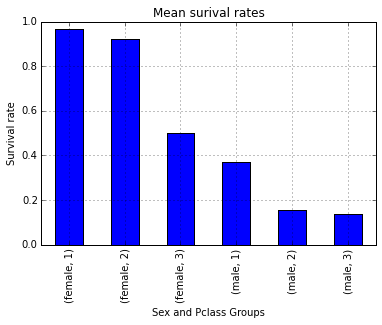

In [356]:
data.groupby(['Sex','Pclass'])['Survived'].mean().plot(kind='bar', title='Mean surival rates')
plt.xlabel('Sex and Pclass Groups')
plt.ylabel('Survival rate')

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x1FD639B0>,
        <matplotlib.axes._subplots.AxesSubplot object at 0x21581050>]], dtype=object)

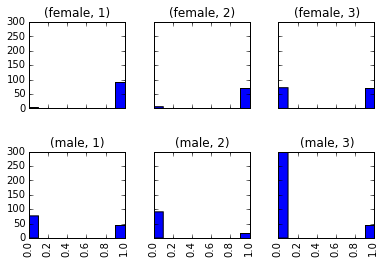

In [357]:
#determine the deaths and survivals for each group of Sex and Pclass
data.Survived.hist(by=[data.Sex,data.Pclass], sharex=True, sharey=True, layout=(2, 3)) 

array([<matplotlib.axes._subplots.AxesSubplot object at 0x1FD77590>,
       <matplotlib.axes._subplots.AxesSubplot object at 0x21A48F70>], dtype=object)

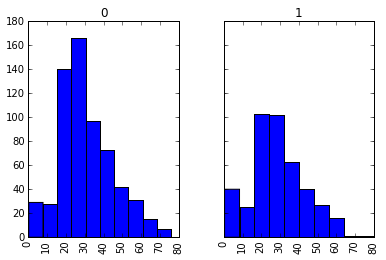

In [358]:
#Explore the difference in survival based on the passengers age
data.Age.hist(by=train.Survived, sharex=True, sharey=True)

# Impute Missing Values

#### Age and Cabin have the most missing values
I hypothesize that both variables are important as a passengers age and proximity to a lifeboat may impact their survival rate. <br/>

To impute age, I will first extract out the title from the Name column (e.g. Mr, Mrs, Miss, Master). Using the Title and Pclass, I will determine a mean age to impute for each group. 

In [359]:
#Age and Cabin have the most missing values
data.isnull().sum()

Age             263
Cabin          1014
Embarked          2
Fare              1
Name              0
Parch             0
PassengerId       0
Pclass            0
Sex               0
SibSp             0
Survived        418
Ticket            0
dtype: int64

####  Missing  Age Values

In [360]:
#Extract Title to calculate missing Age values
data['Title'] = [name.split(',')[1].split('.')[0] for name in data.Name]
set(data.Title) #List the unique titles

{' Capt',
 ' Col',
 ' Don',
 ' Dona',
 ' Dr',
 ' Jonkheer',
 ' Lady',
 ' Major',
 ' Master',
 ' Miss',
 ' Mlle',
 ' Mme',
 ' Mr',
 ' Mrs',
 ' Ms',
 ' Rev',
 ' Sir',
 ' the Countess'}

In [361]:
#Calculate the % of missing Age values, grouped by Sex, Pclass, and Title
data.groupby(['Pclass','Title']).Age.apply(lambda x: x.isnull().sum()) / data.groupby(['Pclass','Title']).Age.count()

Pclass  Title        
1        Capt            0.000000
         Col             0.000000
         Don             0.000000
         Dona            0.000000
         Dr              0.200000
         Jonkheer        0.000000
         Lady            0.000000
         Major           0.000000
         Master          0.000000
         Miss            0.016949
         Mlle            0.000000
         Mme             0.000000
         Mr              0.204545
         Mrs             0.149254
         Sir             0.000000
         the Countess    0.000000
2        Dr              0.000000
         Master          0.000000
         Miss            0.041667
         Mr              0.094891
         Mrs             0.018519
         Ms              0.000000
         Rev             0.000000
3        Master          0.216216
         Miss            0.456311
         Mr              0.435897
         Mrs             0.326531
         Ms                   inf
Name: Age, dtype: float64

In [362]:
data.groupby(['Sex','Pclass','Title']).Age.mean()

Sex     Pclass  Title        
female  1        Dona            39.000000
                 Dr              49.000000
                 Lady            48.000000
                 Miss            30.338983
                 Mlle            24.000000
                 Mme             24.000000
                 Mrs             43.208955
                 the Countess    33.000000
        2        Miss            20.717083
                 Mrs             33.518519
                 Ms              28.000000
        3        Miss            17.360874
                 Mrs             32.326531
                 Ms                    NaN
male    1        Capt            70.000000
                 Col             54.000000
                 Don             40.000000
                 Dr              44.750000
                 Jonkheer        38.000000
                 Major           48.500000
                 Master           6.984000
                 Mr              41.450758
                 Sir    

Third class passengers are most likely to have missing values for age
as well Mr, Mrs, and Doctor in first class

These mean values change alot by title in each class - as much ass ten years
-group by Sex, Pclass, and Title to account for these changes in age

In [363]:
#Fill in Missing values with the mean of passengers with the same Pclass, and Title
fill_mean = lambda g: g.fillna(g.mean())
data.Age = data.groupby(['Pclass','Title']).transform(fill_mean)['Age']                                                     

### Missing Embarked Values

In [364]:
#Fill in missing Embarked values with the most common embarked location
data.Embarked.fillna(data.Embarked.max(), inplace=True)

# Feature Extraction

Ideas for later: <br/> 
-group families: passengers with the same last name (in the Name Field) and # of familiy members on-board (i.e. sum of Parch+SibSp) <br/> 
-Extract Ticket code

In [365]:
tickets = [code.split(' ')[0] if len(code.split(' ')) == 2 else '' for code in data.Ticket]
set(tickets)

{'',
 'A./5.',
 'A.5.',
 'A/4',
 'A/4.',
 'A/5',
 'A/5.',
 'A/S',
 'A4.',
 'AQ/3.',
 'AQ/4',
 'C',
 'C.A.',
 'C.A./SOTON',
 'CA',
 'CA.',
 'F.C.',
 'F.C.C.',
 'Fa',
 'LP',
 'P/PP',
 'PC',
 'PP',
 'S.C./A.4.',
 'S.C./PARIS',
 'S.O./P.P.',
 'S.O.C.',
 'S.O.P.',
 'S.P.',
 'S.W./PP',
 'SC',
 'SC/A.3',
 'SC/A4',
 'SC/AH',
 'SC/PARIS',
 'SC/Paris',
 'SCO/W',
 'SO/C',
 'SOTON/O.Q.',
 'SOTON/O2',
 'SOTON/OQ',
 'STON/O2.',
 'STON/OQ.',
 'SW/PP',
 'W./C.',
 'W.E.P.',
 'W/C',
 'WE/P'}

In [366]:
#Reduce the above ticket groupings by only taking the first letter as there seems to be logical groups
data.Ticket = [code.split(' ')[0][0] if len(code.split(' ')) == 2 else 'no_code' for code in data.Ticket]
set(data.Ticket)

{'A', 'C', 'F', 'L', 'P', 'S', 'W', 'no_code'}

In [367]:
# Create a proxy variable representing whether the Spouse was on board
data['Spouse'] = ((data.Age > 18) & (data.SibSp >= 1)).astype(int)
data.Spouse.value_counts()
data.groupby(['Pclass', 'Spouse']).Survived.mean() # Having a spouse appears to increase survival in the 1st class only

Pclass  Spouse
1       0         0.575342
        1         0.742857
2       0         0.473684
        1         0.470588
3       0         0.247642
        1         0.208955
Name: Survived, dtype: float64

# Models

I will need to transform the following variables: <br/>
Cabin <br/>
Embarked <br/>
Name - I will leave this off the model for now <br/>
Sex <br/>
Ticket <br/>
Title <br/>

In [368]:
data[0:1]

,Age,Cabin,Embarked,Fare,Name,Parch,PassengerId,Pclass,Sex,SibSp,Survived,Ticket,Title,Spouse
0,22,NaN,S,7.25,"Braund, Mr. Owen Harris",0,1,3,male,1,0,A,Mr,1


#### Convert all variables to numeric so for scikit learn

In [369]:
#Change gender to 1 for female and 0 for male
data['Sex'] = np.where(data.Sex == 'female', 1, 0)

In [370]:
Embarked_map = {'S':0, 'C':1, 'Q':2} #create dict of numbers to map for Embarked locations
data.Embarked = data.Embarked.map(Embarked_map)

In [371]:
#Ticket_map = {'A':0, 'C':1, 'F':2, 'L':3, 'P':4, 'S':5, 'W':6, 'no_code':7} #create dict of numbers to map for Ticket Codes
#data.Ticket = data.Ticket.map(Ticket_map)

In [372]:
#Create dummy variables for Title
data = pd.concat([data, pd.get_dummies(data.Ticket)], axis=1)
data[0:1]

,Age,Cabin,Embarked,Fare,Name,Parch,PassengerId,Pclass,Sex,SibSp,...,Title,Spouse,A,C,F,L,P,S,W,no_code
0,22,NaN,0,7.25,"Braund, Mr. Owen Harris",0,1,3,0,1,...,Mr,1,1,0,0,0,0,0,0,0


In [373]:
#Create dummy variables for Title
data = pd.concat([data, pd.get_dummies(data.Title)], axis=1)
data[0:1]

,Age,Cabin,Embarked,Fare,Name,Parch,PassengerId,Pclass,Sex,SibSp,...,Master,Miss,Mlle,Mme,Mr,Mrs,Ms,Rev,Sir,the Countess
0,22,NaN,0,7.25,"Braund, Mr. Owen Harris",0,1,3,0,1,...,0,0,0,0,1,0,0,0,0,0


In [374]:
#subset training data for model creation
print len(train) #determine length of original train data set and use that to subset 'data'
training = data[0:891]

891


### KNN

In [377]:
# Step 1 Split the data into training and testing data sets
X = training.drop(['Survived','Cabin','Name','Title','Ticket'], axis=1)
y = training['Survived']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state = 1)

In [378]:
# Step 2: train the model on the training set (using K=25)
knn = KNeighborsClassifier(n_neighbors=25)
knn.fit(X_train, y_train)

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_neighbors=25, p=2, weights='uniform')

In [393]:
# Step 3: test the model on the testing set, and check the accuracy
y_pred = knn.predict(X_test)
print metrics.accuracy_score(y_test, y_pred)

0.641791044776


### Decision Tree

In [388]:
# Create a decision tree classifier instance (start out with a small tree for interpretability)
ctree = tree.DecisionTreeClassifier(random_state=1, max_depth=3)

# Fit the decision tree classider
ctree.fit(X_train, y_train)

# Create a feature vector
features = X_train.columns.tolist()

# Which features are the most important?
pd.DataFrame(zip(features, ctree.feature_importances_)).sort_index(by=1, ascending=False)


,0,1
29,Mr,0.656062
5,Pclass,0.167297
2,Fare,0.075075
32,Rev,0.053673
4,PassengerId,0.047893
26,Miss,0.000000
21,Dr,0.000000
22,Jonkheer,0.000000
23,Lady,0.000000
24,Major,0.000000


In [389]:
# Make predictions on the test set
y_pred = ctree.predict(X_test)

# Calculate accuracy
metrics.accuracy_score(y_test, y_pred)

0.77985074626865669